In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q /content/drive/MyDrive/CCTV.zip

# 🔵 **Dependncies**

In [3]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 55.1 MB/s eta 0:00:00


In [4]:
!pip install -q pyyaml

# 🔵 Before you start

In [5]:
!nvidia-smi

Fri Jun 21 14:23:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [6]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [7]:
!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 31.1/78.2 GB disk)


In [8]:
from ultralytics import YOLO

from IPython.display import display, Image

# 🔵 **Utils**

In [9]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [12]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [13]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

# 🔵 **Import**

In [15]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Dataset

import torchvision
from torchvision import transforms as T
from torchvision import models
from torchvision.models.detection.backbone_utils import BackboneWithFPN

import albumentations as A

import torchmetrics as tm

from sklearn.model_selection import train_test_split

from matplotlib.patches import Rectangle

from torchmetrics.detection import MeanAveragePrecision

import json

from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os
import copy
import yaml
import shutil
from IPython import display
from google.colab import files

In [16]:
print('torch version: ', torch.__version__)
print('torchvision version: ', torchvision.__version__)
print('numpy version: ', np.__version__)
print('pandas version: ', pd.__version__)
print('albumentation version: ', A.__version__)
print('torchmetrics version: ', tm.__version__)

torch version:  2.3.0+cu121
torchvision version:  0.18.0+cu121
numpy version:  1.25.2
pandas version:  2.0.3
albumentation version:  1.3.1
torchmetrics version:  1.4.0.post0


# 🔵 **Dataset**

## 🔵 **Look samples**

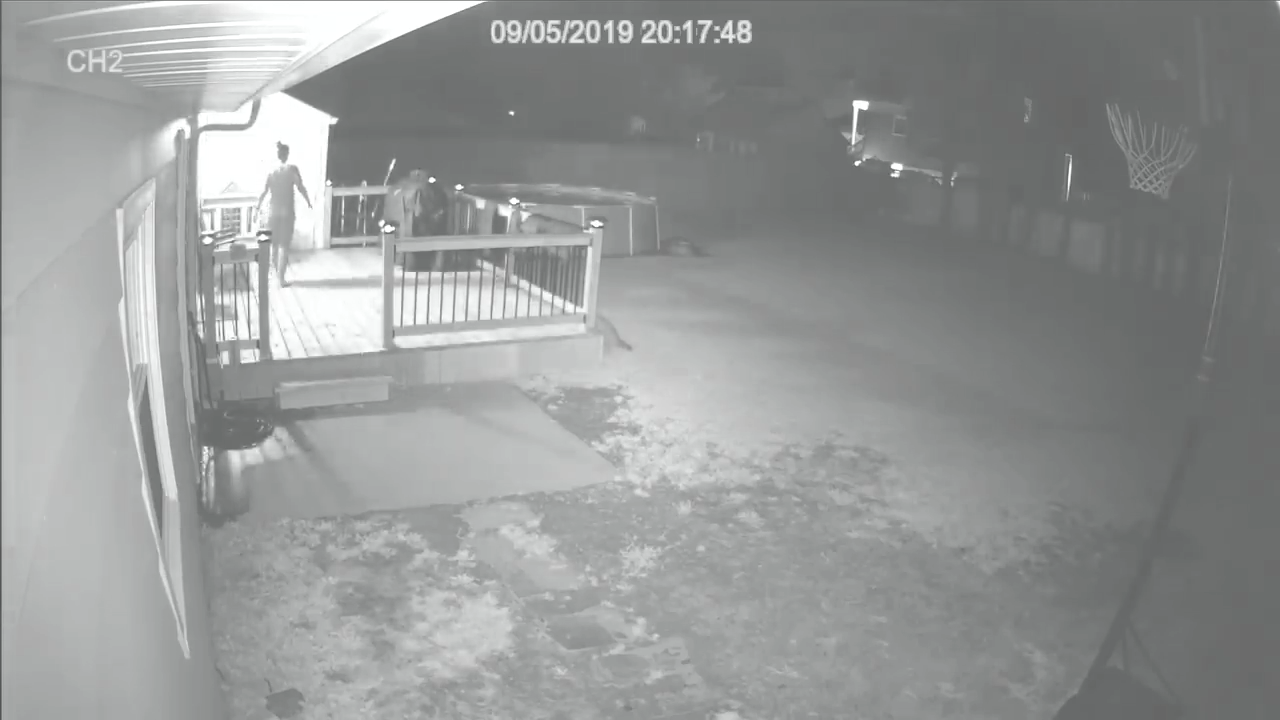

In [17]:
image = Image.open('/content/Images/CCTV_103.png').convert('RGB')
image

In [18]:
images_name = os.listdir('/content/Images/')
len(images_name)

700

In [19]:
images_ann = json.load(open('/content/CCTVAnnotations.json'))['images']
annotation = json.load(open('/content/CCTVAnnotations.json'))['annotations']
categories = json.load(open('/content/CCTVAnnotations.json'))['categories']
len(images_ann), len(annotation)

(700, 933)

In [20]:
images_ann = pd.DataFrame(images_ann)
images_ann

id     file_name  height  width  license
0      1    CCTV_1.png     720   1280        1
1      2    CCTV_2.png     288    384        1
2      3    CCTV_3.png    1080   1920        1
3      4    CCTV_4.png     480    854        1
4      5    CCTV_5.png     425    634        1
..   ...           ...     ...    ...      ...
695  696  CCTV_696.png     720   1280        1
696  697  CCTV_697.png     720   1280        1
697  698  CCTV_698.png     480    704        1
698  699  CCTV_699.png     360    480        1
699  700  CCTV_700.png     720   1280        1

[700 rows x 5 columns]

In [21]:
annotation = pd.DataFrame(annotation)
annotation

id  image_id  iscrowd                              bbox    area  \
0      1         1        0  [617.18, 101.71, 119.27, 226.78]   27048   
1      2         2        0     [188.63, 136.61, 44.31, 29.9]    1324   
2      3         3        0   [1370.66, 255.98, 35.09, 91.16]    3198   
3      4         3        0     [9.91, 81.62, 1329.1, 218.45]  290341   
4      5         4        0   [130.37, 162.24, 44.98, 106.72]    4800   
..   ...       ...      ...                               ...     ...   
928  929       696        0     [184.93, 78.3, 97.56, 218.27]   21294   
929  930       697        0   [272.04, 226.98, 54.56, 133.95]    7308   
930  931       698        0     [187.72, 143.88, 64.4, 72.05]    4640   
931  932       699        0    [232.53, 52.82, 66.41, 128.02]    8501   
932  933       700        0  [916.35, 192.13, 108.58, 228.18]   24775   

     num_keypoints                                          keypoints  \
0               13  [623.08, 115.95, 2, 624.5, 108.02, 2, 0, 0, 0,...   
1               17  [204.43, 140.91, 2, 204.08, 139.46, 2, 202.74,...   
2               17  [1394.21, 260.05, 2, 1395.92, 257.5, 2, 1392.5...   
3               16  [1334.58, 209.97, 2, 0, 0, 0, 1330.69, 208.99,...   
4               15  [135.51, 165.24, 2, 136.44, 162.24, 2, 0, 0, 0...   
..             ...                                                ...   
928             16  [233.39, 86.74, 2, 234.53, 78.3, 2, 225.3, 81....   
929             11  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
930             11  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
931             14  [285.09, 54.86, 2, 287.99, 52.82, 2, 0, 0, 0, ...   
932             15  [989.21, 199.91, 2, 996.74, 192.86, 2, 988.73,...   

     category_id  
0              1  
1              1  
2              1  
3              1  
4              1  
..           ...  
928            1  
929            1  
930            1  
931            1  
932            1  

[933 rows x 8 columns]

In [22]:
annotation[annotation['image_id'] == 3]

id  image_id  iscrowd                             bbox    area  \
2   3         3        0  [1370.66, 255.98, 35.09, 91.16]    3198   
3   4         3        0    [9.91, 81.62, 1329.1, 218.45]  290341   

   num_keypoints                                          keypoints  \
2             17  [1394.21, 260.05, 2, 1395.92, 257.5, 2, 1392.5...   
3             16  [1334.58, 209.97, 2, 0, 0, 0, 1330.69, 208.99,...   

   category_id  
2            1  
3            1

In [23]:
images_name = []
for id in annotation['image_id']:
  images_name.append(images_ann[images_ann['id'] == id]['file_name'].values[0])

In [24]:
annotation['file_name'] = images_name

In [25]:
annotation

id  image_id  iscrowd                              bbox    area  \
0      1         1        0  [617.18, 101.71, 119.27, 226.78]   27048   
1      2         2        0     [188.63, 136.61, 44.31, 29.9]    1324   
2      3         3        0   [1370.66, 255.98, 35.09, 91.16]    3198   
3      4         3        0     [9.91, 81.62, 1329.1, 218.45]  290341   
4      5         4        0   [130.37, 162.24, 44.98, 106.72]    4800   
..   ...       ...      ...                               ...     ...   
928  929       696        0     [184.93, 78.3, 97.56, 218.27]   21294   
929  930       697        0   [272.04, 226.98, 54.56, 133.95]    7308   
930  931       698        0     [187.72, 143.88, 64.4, 72.05]    4640   
931  932       699        0    [232.53, 52.82, 66.41, 128.02]    8501   
932  933       700        0  [916.35, 192.13, 108.58, 228.18]   24775   

     num_keypoints                                          keypoints  \
0               13  [623.08, 115.95, 2, 624.5, 108.02, 2, 0, 0, 0,...   
1               17  [204.43, 140.91, 2, 204.08, 139.46, 2, 202.74,...   
2               17  [1394.21, 260.05, 2, 1395.92, 257.5, 2, 1392.5...   
3               16  [1334.58, 209.97, 2, 0, 0, 0, 1330.69, 208.99,...   
4               15  [135.51, 165.24, 2, 136.44, 162.24, 2, 0, 0, 0...   
..             ...                                                ...   
928             16  [233.39, 86.74, 2, 234.53, 78.3, 2, 225.3, 81....   
929             11  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
930             11  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
931             14  [285.09, 54.86, 2, 287.99, 52.82, 2, 0, 0, 0, ...   
932             15  [989.21, 199.91, 2, 996.74, 192.86, 2, 988.73,...   

     category_id     file_name  
0              1    CCTV_1.png  
1              1    CCTV_2.png  
2              1    CCTV_3.png  
3              1    CCTV_3.png  
4              1    CCTV_4.png  
..           ...           ...  
928            1  CCTV_696.png  
929            1  CCTV_697.png  
930            1  CCTV_698.png  
931            1  CCTV_699.png  
932            1  CCTV_700.png  

[933 rows x 9 columns]

In [26]:
def show_random_joints_on_image(annotation, data_dir, number):
  images_name = np.unique(np.array(annotation['file_name'].values))
  r = random.sample(range(0, len(images_name)), number)
  plt.figure(figsize = (20, 20 ))
  plt.subplot(int(np.sqrt(number)) + 1, int(np.sqrt(number)) + 1, 1)
  id = images_name[r[0]]
  joints = np.array([j for j in annotation[annotation['file_name'] == id]['keypoints'].values]).tolist()
  boxs = np.array([k for k in annotation[annotation['file_name'] == id]['bbox'].values]).tolist()
  def plot(id, joints, boxs):
    for i in range(len(boxs)):
      joint = np.array(joints[i])
      box = boxs[i]

      x = joint[0::3]
      y = joint[1::3]
      v = joint[2::3]
      im = Image.open(f'{data_dir}/{id}').convert('RGB')
      plt.imshow(im)
      plt.scatter(x, y)
      ax = plt.gca()
      rect =  Rectangle((box[0], box[1]),
                        (box[2]),
                        (box[3]),
                        fill = False,
                        edgecolor = (1, 0, 0),
                        linewidth = 2)
      ax.add_patch(rect)

  plot(id, joints, boxs)
  plt.axis('off')
  for i in range(number - 1):
    plt.subplot(int(np.sqrt(number)) + 1, int(np.sqrt(number)) + 1 , i+2)
    id = images_name[r[i+1]]
    joints = np.array([j for j in annotation[annotation['file_name'] == id]['keypoints'].values]).tolist()
    boxs = np.array([k for k in annotation[annotation['file_name'] == id]['bbox'].values]).tolist()
    plot(id, joints, boxs)
    plt.axis('off')
  plt.show()

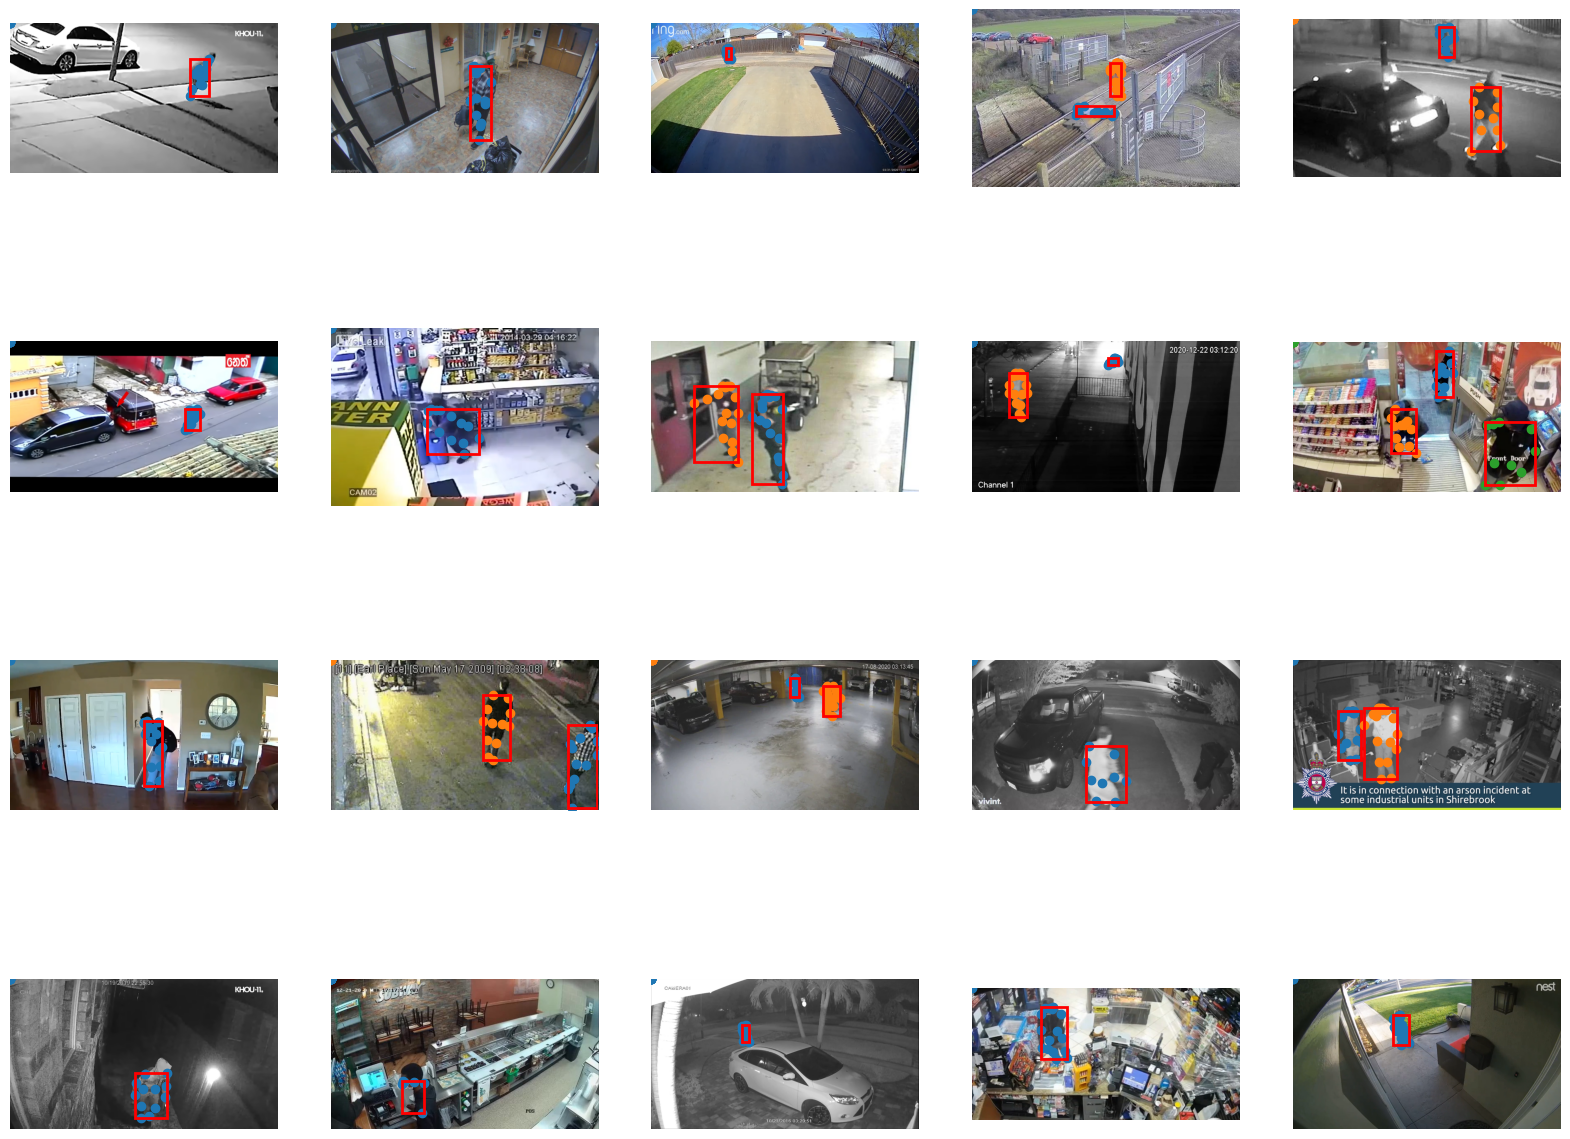

In [27]:
show_random_joints_on_image(annotation, '/content/Images', 20)

## 🔵 **Split**

In [28]:
images_name = np.array(np.unique(annotation['file_name'].tolist()))
images_name.shape

(700,)

In [29]:
train_im, valid_im = train_test_split(images_name, test_size = 0.3, random_state = 42)
valid_im, test_im  = train_test_split(valid_im, test_size = 0.5, random_state = 42)
train_im.shape, valid_im.shape, test_im.shape

((490,), (105,), (105,))

In [30]:
def change(file):
  new = []
  for id in file:
    [new.append(v) for v in annotation[annotation['file_name'] == id].values.tolist()]

  return pd.DataFrame(new, columns = annotation.columns)
train_df = change(train_im)
valid_df = change(valid_im)
test_df  = change(test_im)
train_df.shape, valid_df.shape, test_df.shape

((642, 9), (151, 9), (140, 9))

In [31]:
train_df[train_df['file_name'] == 'CCTV_294.png']['bbox'].values[0][3] = 352.5
train_df[train_df['file_name'] == 'CCTV_501.png']['bbox'].values[0][3] = 464.2
valid_df[valid_df['file_name'] == 'CCTV_241.png']['bbox'].values[0][3] = 372

In [32]:
train_df

id  image_id  iscrowd                              bbox    area  \
0    569       420        0    [787.67, 354.0, 209.81, 232.3]   48738   
1    570       420        0  [430.95, 221.36, 223.57, 457.21]  102218   
2    914       684        0   [814.64, 124.04, 77.91, 199.73]   15560   
3    485       361        0   [117.51, 131.01, 56.43, 140.76]    7943   
4    638       478        0    [271.24, 257.41, 88.15, 196.0]   17277   
..   ...       ...      ...                               ...     ...   
637  255       195        0  [332.28, 182.41, 128.05, 190.91]   24446   
638  458       342        0    [208.69, 107.23, 35.25, 55.09]    1941   
639  459       342        0       [3.63, 94.09, 39.47, 18.25]     720   
640  655       491        0     [200.05, 66.48, 23.83, 37.72]     898   
641  249       191        0    [692.47, 435.74, 79.27, 188.9]   14974   

     num_keypoints                                          keypoints  \
0                9  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1               12  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2               11  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 865.88, 1...   
3               17  [141.71, 135.79, 2, 143.34, 131.01, 2, 138.24,...   
4               16  [288.96, 262.37, 2, 292.1, 257.41, 2, 287.16, ...   
..             ...                                                ...   
637             15  [419.77, 193.48, 2, 0, 0, 0, 414.87, 187.45, 2...   
638             12  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
639              6  [0, 0, 0, 0, 0, 0, 3.63, 0, 0, 0, 0, 0, 0, 0, ...   
640             14  [223.49, 68.51, 2, 223.88, 66.88, 2, 222.98, 6...   
641             17  [731.58, 443.66, 2, 734.29, 440.88, 2, 728.53,...   

     category_id     file_name  
0              1  CCTV_420.png  
1              1  CCTV_420.png  
2              1  CCTV_684.png  
3              1  CCTV_361.png  
4              1  CCTV_478.png  
..           ...           ...  
637            1  CCTV_195.png  
638            1  CCTV_342.png  
639            1  CCTV_342.png  
640            1  CCTV_491.png  
641            1  CCTV_191.png  

[642 rows x 9 columns]

In [33]:
def preprocessing(data, image_names):
  images = []
  bboxes = []
  labels = []
  keypoints = []
  for image in image_names:
    sample_info = data[data['file_name'] == image]
    bbox        = [[sample_info['bbox'].iloc[i][0] + sample_info['bbox'].iloc[i][2]/2, sample_info['bbox'].iloc[i][1] + sample_info['bbox'].iloc[i][3]/2,
                    sample_info['bbox'].iloc[i][2], sample_info['bbox'].iloc[i][3]] for i in range(sample_info.shape[0])]

    keyp       = [sample_info['keypoints'].iloc[i] for i in range(sample_info.shape[0])]

    label = [0] * len(bbox)

    images.append(image)
    bboxes.append(bbox)
    labels.append(label)
    keypoints.append(keyp)

  return pd.DataFrame([images, bboxes, labels, keypoints], index = ['image_names', 'bboxes', 'labels', 'keypoints']).transpose()


In [34]:
train_df = preprocessing(train_df, train_im)
valid_df = preprocessing(valid_df, valid_im)
test_df  = preprocessing(test_df, test_im)
train_df.shape, valid_df.shape, test_df.shape

((490, 4), (105, 4), (105, 4))

In [35]:
train_df.to_csv('train_df.csv')
valid_df.to_csv('valid_df.csv')
test_df.to_csv('test_df.csv')

## 🔵 **Create Label files**

In [36]:
!mkdir /content/datasets

In [37]:
try:
  print(os.listdir('/content/datasets/CCTV/'))
  print('!all folder already exist!')
except:
  !mkdir /content/datasets/CCTV/
  !mkdir /content/datasets/CCTV/train/
  !mkdir /content/datasets/CCTV/train/images/
  !mkdir /content/datasets/CCTV/train/labels/
  !mkdir /content/datasets/CCTV/valid/
  !mkdir /content/datasets/CCTV/valid/images/
  !mkdir /content/datasets/CCTV/valid/labels/
  !mkdir /content/datasets/CCTV/test/
  !mkdir /content/datasets/CCTV/test/images/
  !mkdir /content/datasets/CCTV/test/labels/

In [38]:
try:
  with open('/content/datasets/CCTV/data.yaml') as f:
    print(yaml.safe_load(f)['names'])
  print('!data file already exist!')
except:
  my_dict = {}
  my_dict['names'] = ['human']
  my_dict['kpt_shape'] = [17, 3]
  my_dict['flip_idx'] =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
  #my_dict['nc'] = 1
  my_dict['test'] = 'test/images'
  my_dict['train'] = 'train/images'
  my_dict['val'] = 'valid/images'
  with open('/content/datasets/CCTV/data.yaml', 'w') as outfile:
    yaml.dump(my_dict, outfile, default_flow_style=False)

In [39]:
def create_dataset(df, phase):
  for i in range(df.shape[0]):
    display.clear_output(wait = True)
    sample = df.iloc[i]
    boxes = np.array(sample['bboxes'])
    image = T.functional.to_tensor(Image.open(f"/content/Images/{sample['image_names']}").convert('RGB'))
    height, width = image.shape[1:]
    boxes = np.array(sample['bboxes'])/[width, height, width, height]
    labels = np.array(sample['labels'])
    keyp = np.array(sample['keypoints'])
    for i in range(keyp.shape[0]):
      keyp[i] = keyp[i]/([width, height, 1] * 17)
    infos = np.concatenate((labels.reshape(labels.shape[0], 1), boxes, keyp), axis = 1)
    image_name = sample['image_names']
    try:
      a = Image.open(f"/content/datasets/CCTV/{phase}/images/{image_name}").convert('RGB')
      print(f'image <<{image_name}>> already exist!')
    except:
      shutil.copy(f"/content/Images/{image_name}", f'/content/datasets/CCTV/{phase}/images/')
      print(f'image <<{image_name}>> moved!')
    try:
      a = np.loadtxt(f"/content/datasets/CCTV/{phase}/labels/{image_name.split('.png')[0]}.txt")
      print(f'label <<{image_name}>> already exist!')
    except:
      np.savetxt(f"/content/datasets/CCTV/{phase}/labels/{image_name.split('.png')[0]}.txt", infos)
      print(f"label{image_name.split('.png')[0]}.txt created!")

In [40]:
create_dataset(train_df, 'train')

image <<CCTV_191.png>> moved!
labelCCTV_191.txt created!


In [41]:
create_dataset(valid_df, 'valid')

image <<CCTV_677.png>> moved!
labelCCTV_677.txt created!


In [42]:
create_dataset(test_df, 'test')

image <<CCTV_621.png>> moved!
labelCCTV_621.txt created!


# 🔵 **Train**

In [ ]:
%cd {HOME}

!yolo task=pose mode=train model=yolov8m-pose.pt data=/content/datasets/CCTV/data.yaml epochs=200 batch=32 imgsz=640 plots=True patience=200

In [ ]:
!cp /content/runs/pose/train/weights/best.pt /content/drive/MyDrive/

# 🔵 **Result**

In [ ]:
!ls {HOME}/runs/pose/train/

args.yaml					    labels.jpg	      train_batch2.jpg
BoxF1_curve.png					    PoseF1_curve.png  train_batch3040.jpg
BoxP_curve.png					    PoseP_curve.png   train_batch3041.jpg
BoxPR_curve.png					    PosePR_curve.png  train_batch3042.jpg
BoxR_curve.png					    PoseR_curve.png   val_batch0_labels.jpg
confusion_matrix_normalized.png			    results.csv       val_batch0_pred.jpg
confusion_matrix.png				    results.png       val_batch1_labels.jpg
events.out.tfevents.1718927689.9c2cdd349007.2168.0  train_batch0.jpg  val_batch1_pred.jpg
labels_correlogram.jpg				    train_batch1.jpg  weights


/content


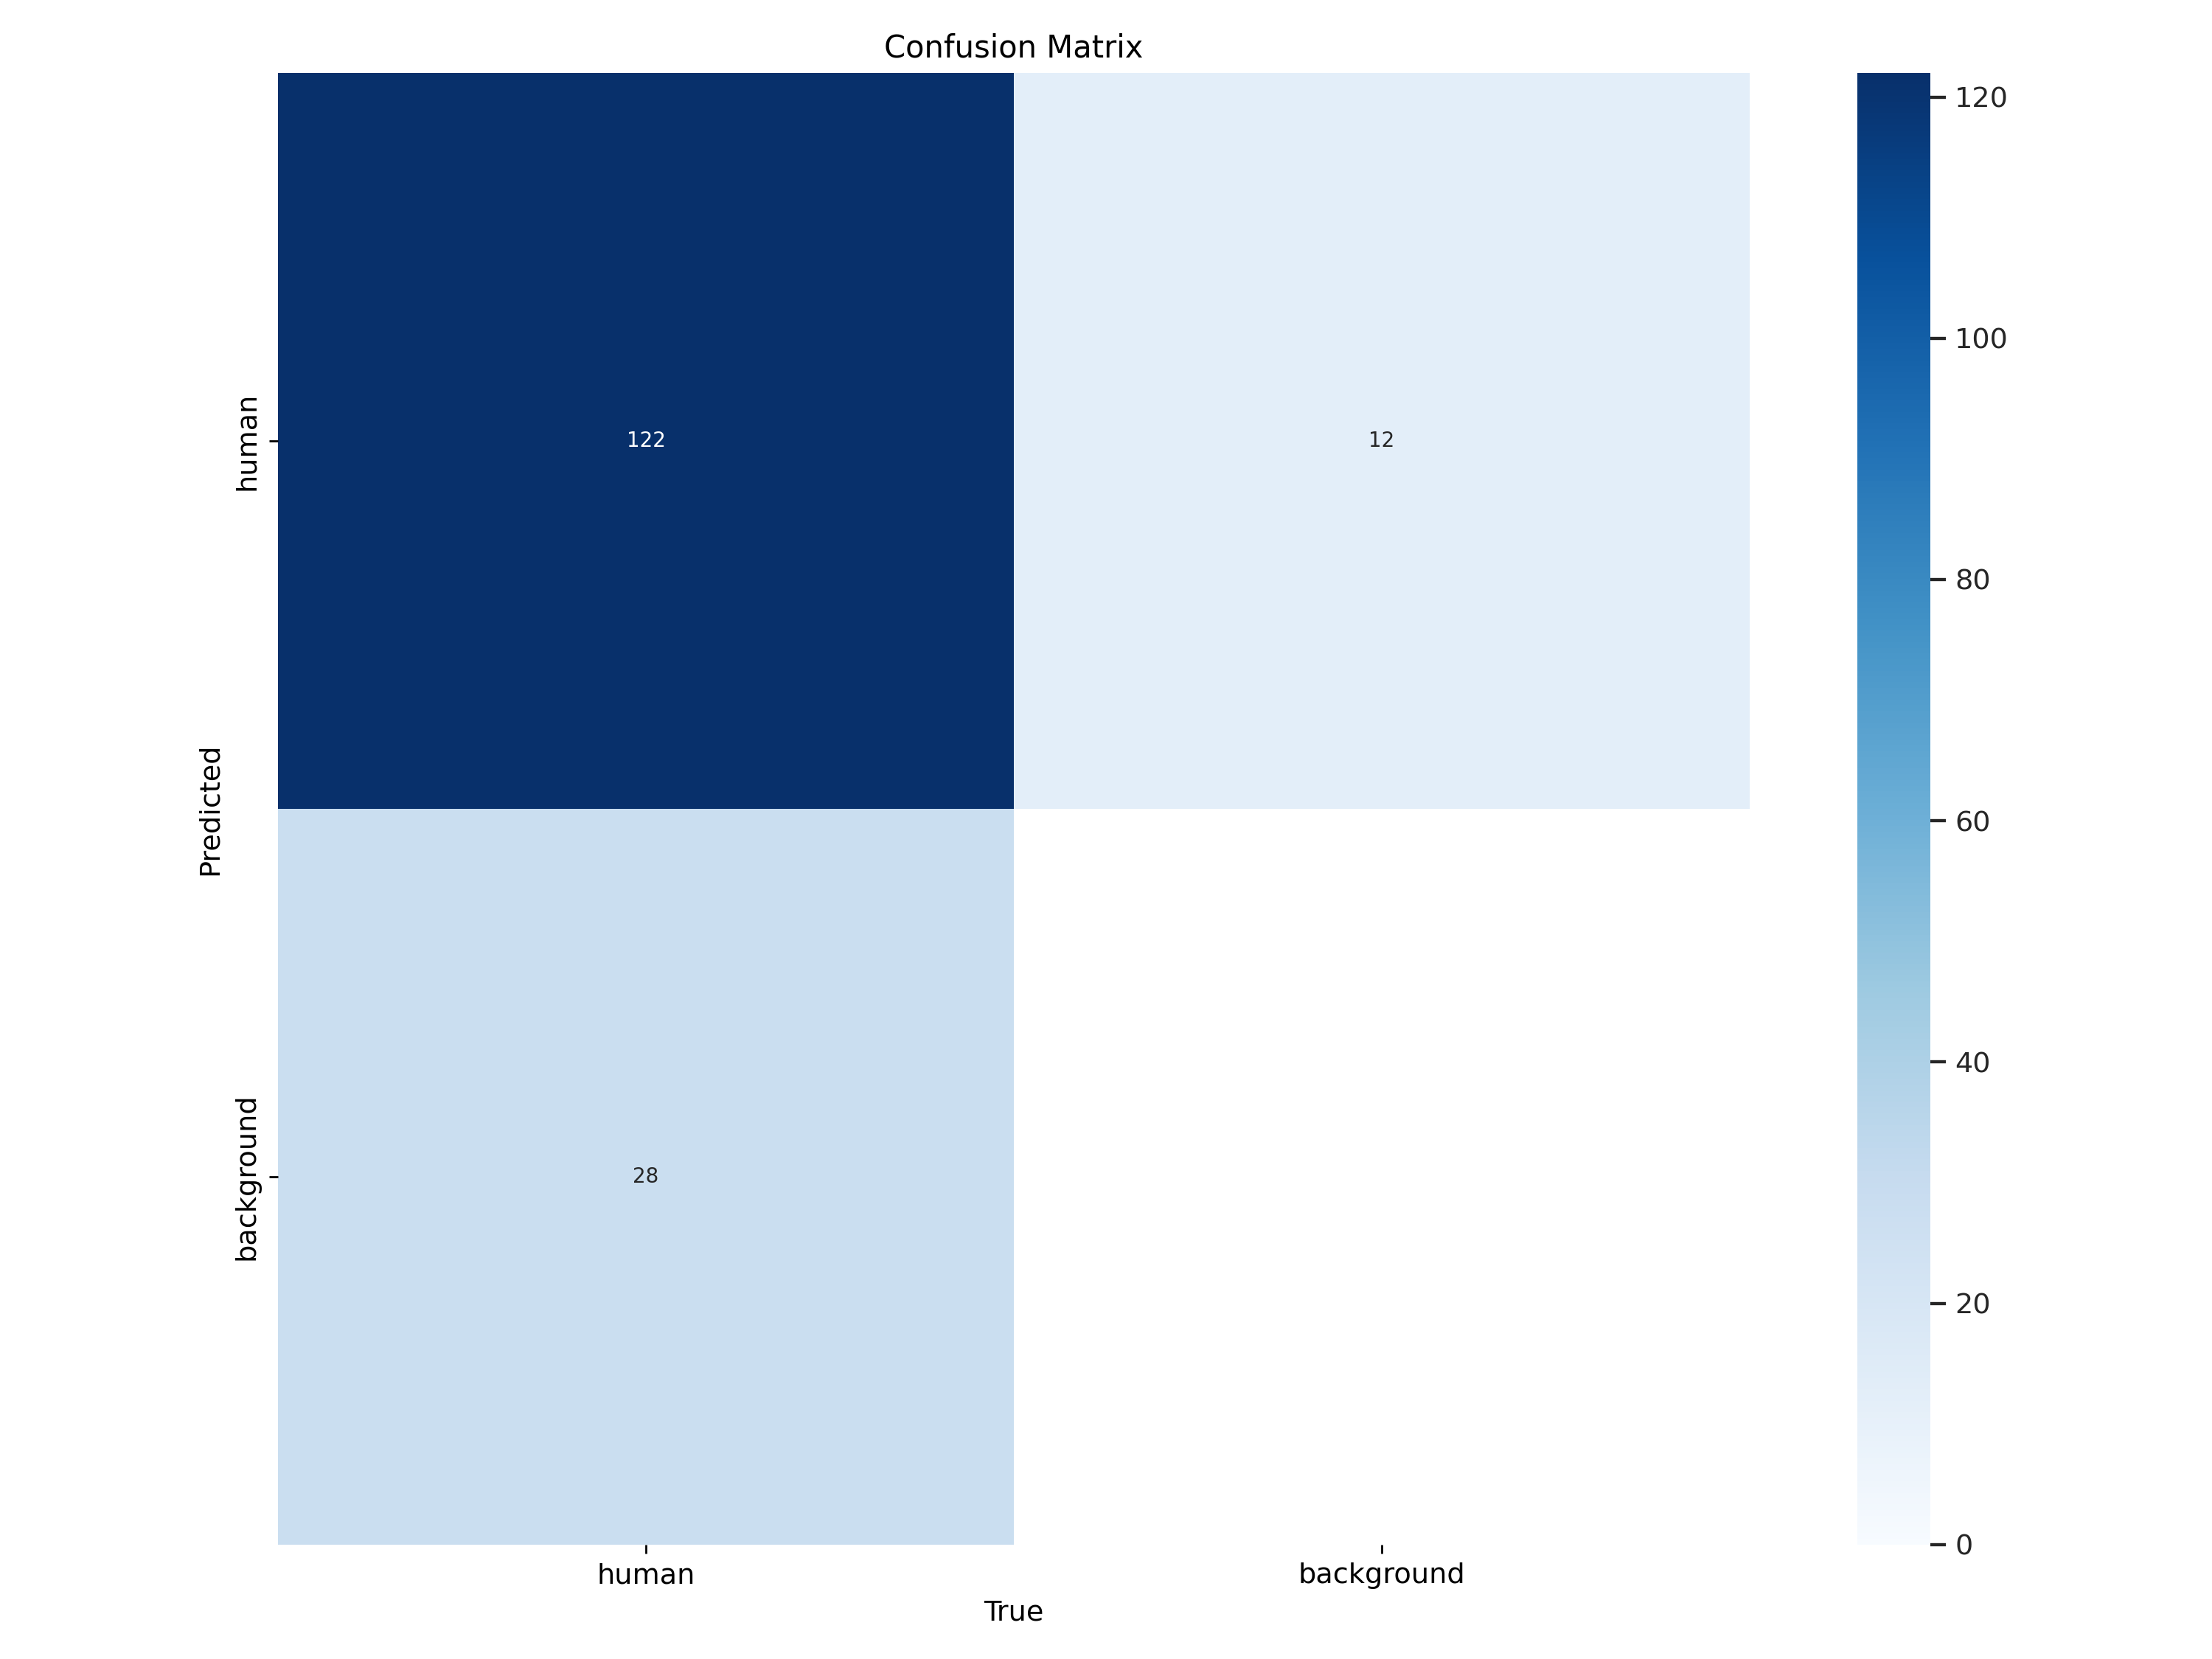

In [ ]:
%cd {HOME}
from IPython.display import Image
Image(filename=f'{HOME}/runs/pose/train/confusion_matrix.png', width=600)

/content


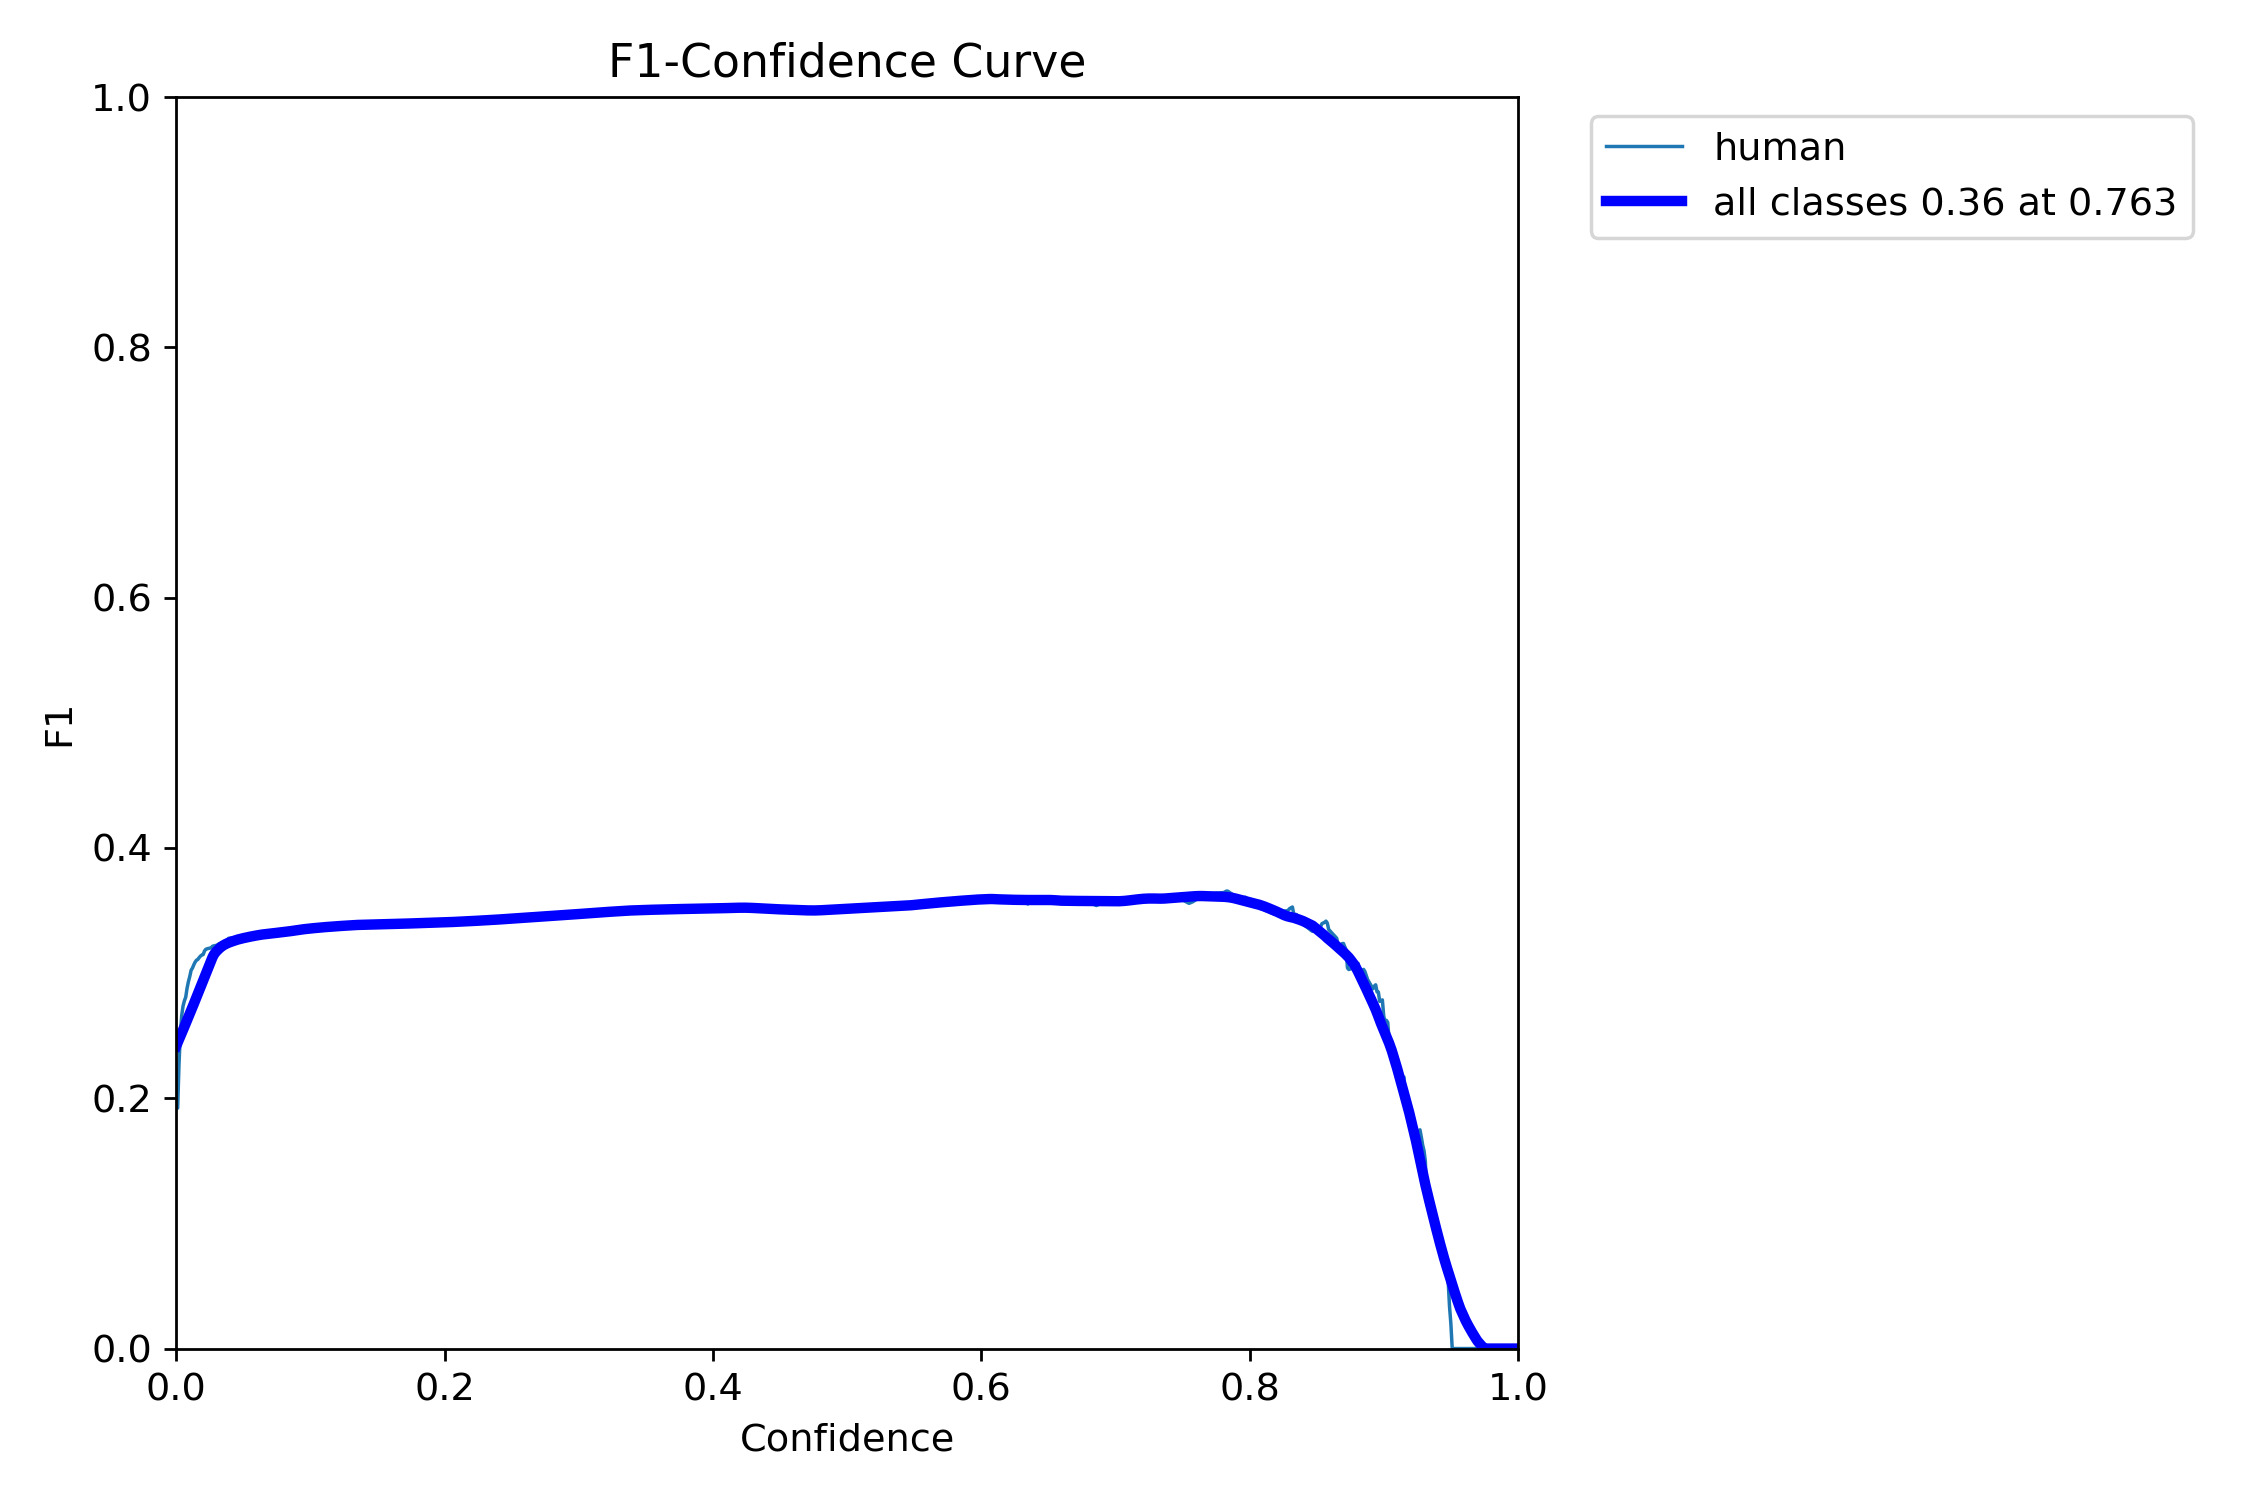

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/pose/train/PoseF1_curve.png', width=600)

/content


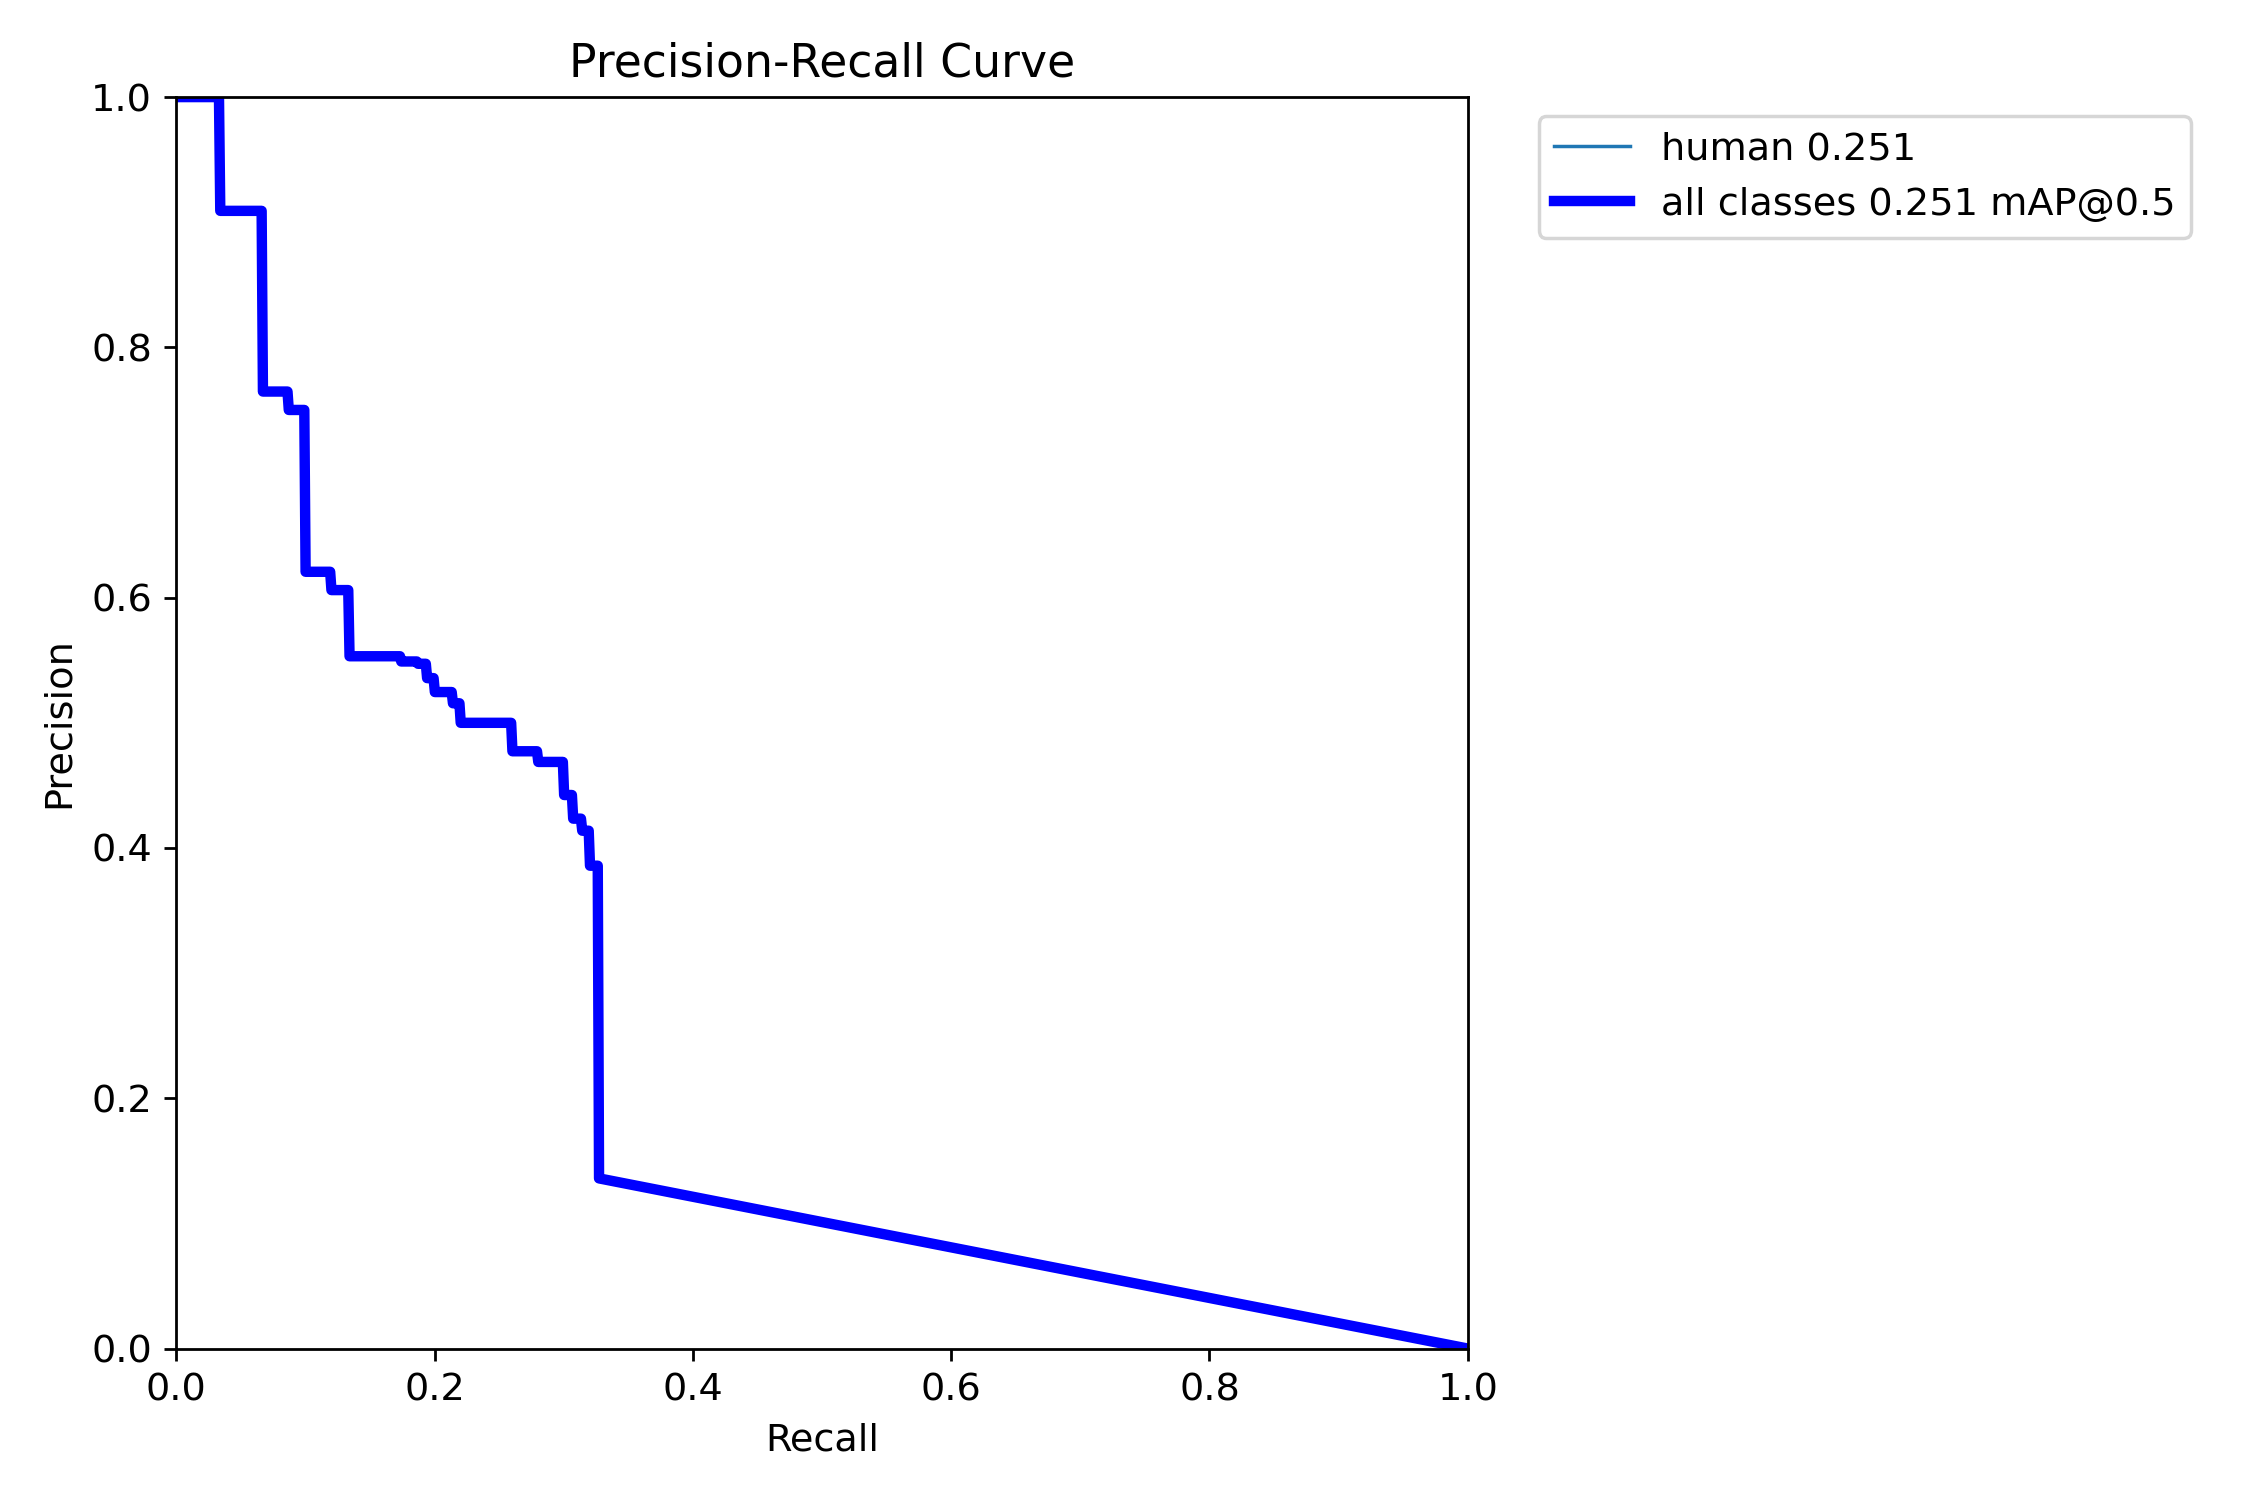

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/pose/train/PosePR_curve.png', width=600)

/content


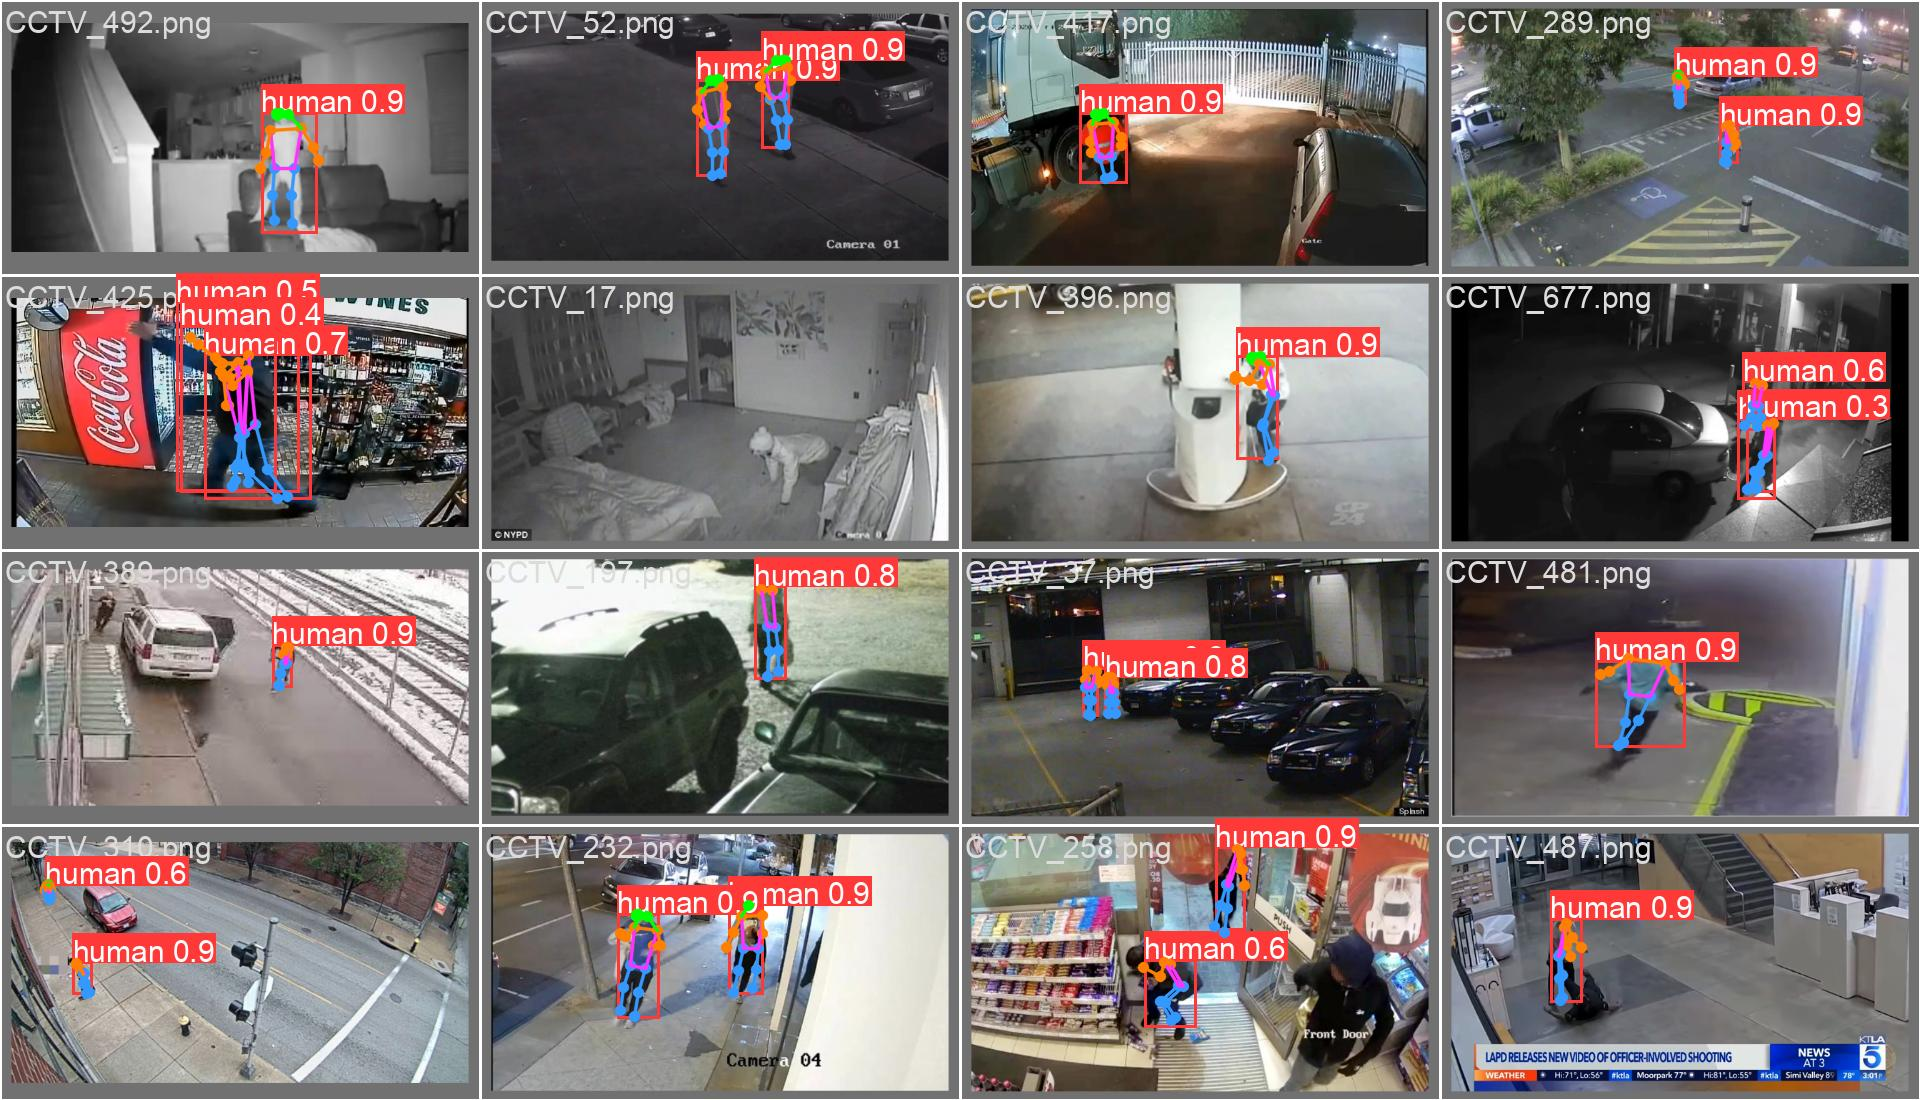

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/runs/pose/train/val_batch0_pred.jpg', width=600)

# 🔵 **validate Custom Model**

In [ ]:
%cd {HOME}

!yolo task=detect mode=val model=/content/runs/pose/train/weights/best.pt data=/content/datasets/CCTV/data.yaml split=val

/content
WARNING ⚠️ conflicting 'task=detect' passed with 'task=pose' model. Ignoring 'task=detect' and updating to 'task=pose' to match model.
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-pose summary (fused): 237 layers, 26447596 parameters, 0 gradients, 81.0 GFLOPs
val: Scanning /content/datasets/CCTV/valid/labels.cache... 105 images, 0 backgrounds, 1 corrupt: 100% 105/105 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/datasets/CCTV/valid/images/CCTV_241.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0004]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100% 7/7 [00:08<00:00,  1.26s/it]
                   all        104        150      0.908      0.793      0.868      0.541       0.44      0.307       0.25     0.0913
Speed: 4.5ms preprocess, 48.7ms inference, 0.0ms loss, 11.6ms postprocess per image
Results saved 

In [ ]:
%cd {HOME}

!yolo task=detect mode=val model=/content/runs/pose/train/weights/best.pt data=/content/datasets/CCTV/data.yaml split=test

/content
WARNING ⚠️ conflicting 'task=detect' passed with 'task=pose' model. Ignoring 'task=detect' and updating to 'task=pose' to match model.
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m-pose summary (fused): 237 layers, 26447596 parameters, 0 gradients, 81.0 GFLOPs
val: Scanning /content/datasets/CCTV/test/labels... 105 images, 0 backgrounds, 0 corrupt: 100% 105/105 [00:00<00:00, 172.14it/s]
val: New cache created: /content/datasets/CCTV/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0% 0/7 [00:00<?, ?it/s]WARNING ⚠️ NMS time limit 1.300s exceeded
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100% 7/7 [00:07<00:00,  1.09s/it]
                   all        105        140      0.931        0.6      0.722       0.47      0.529      0.307      0

/content


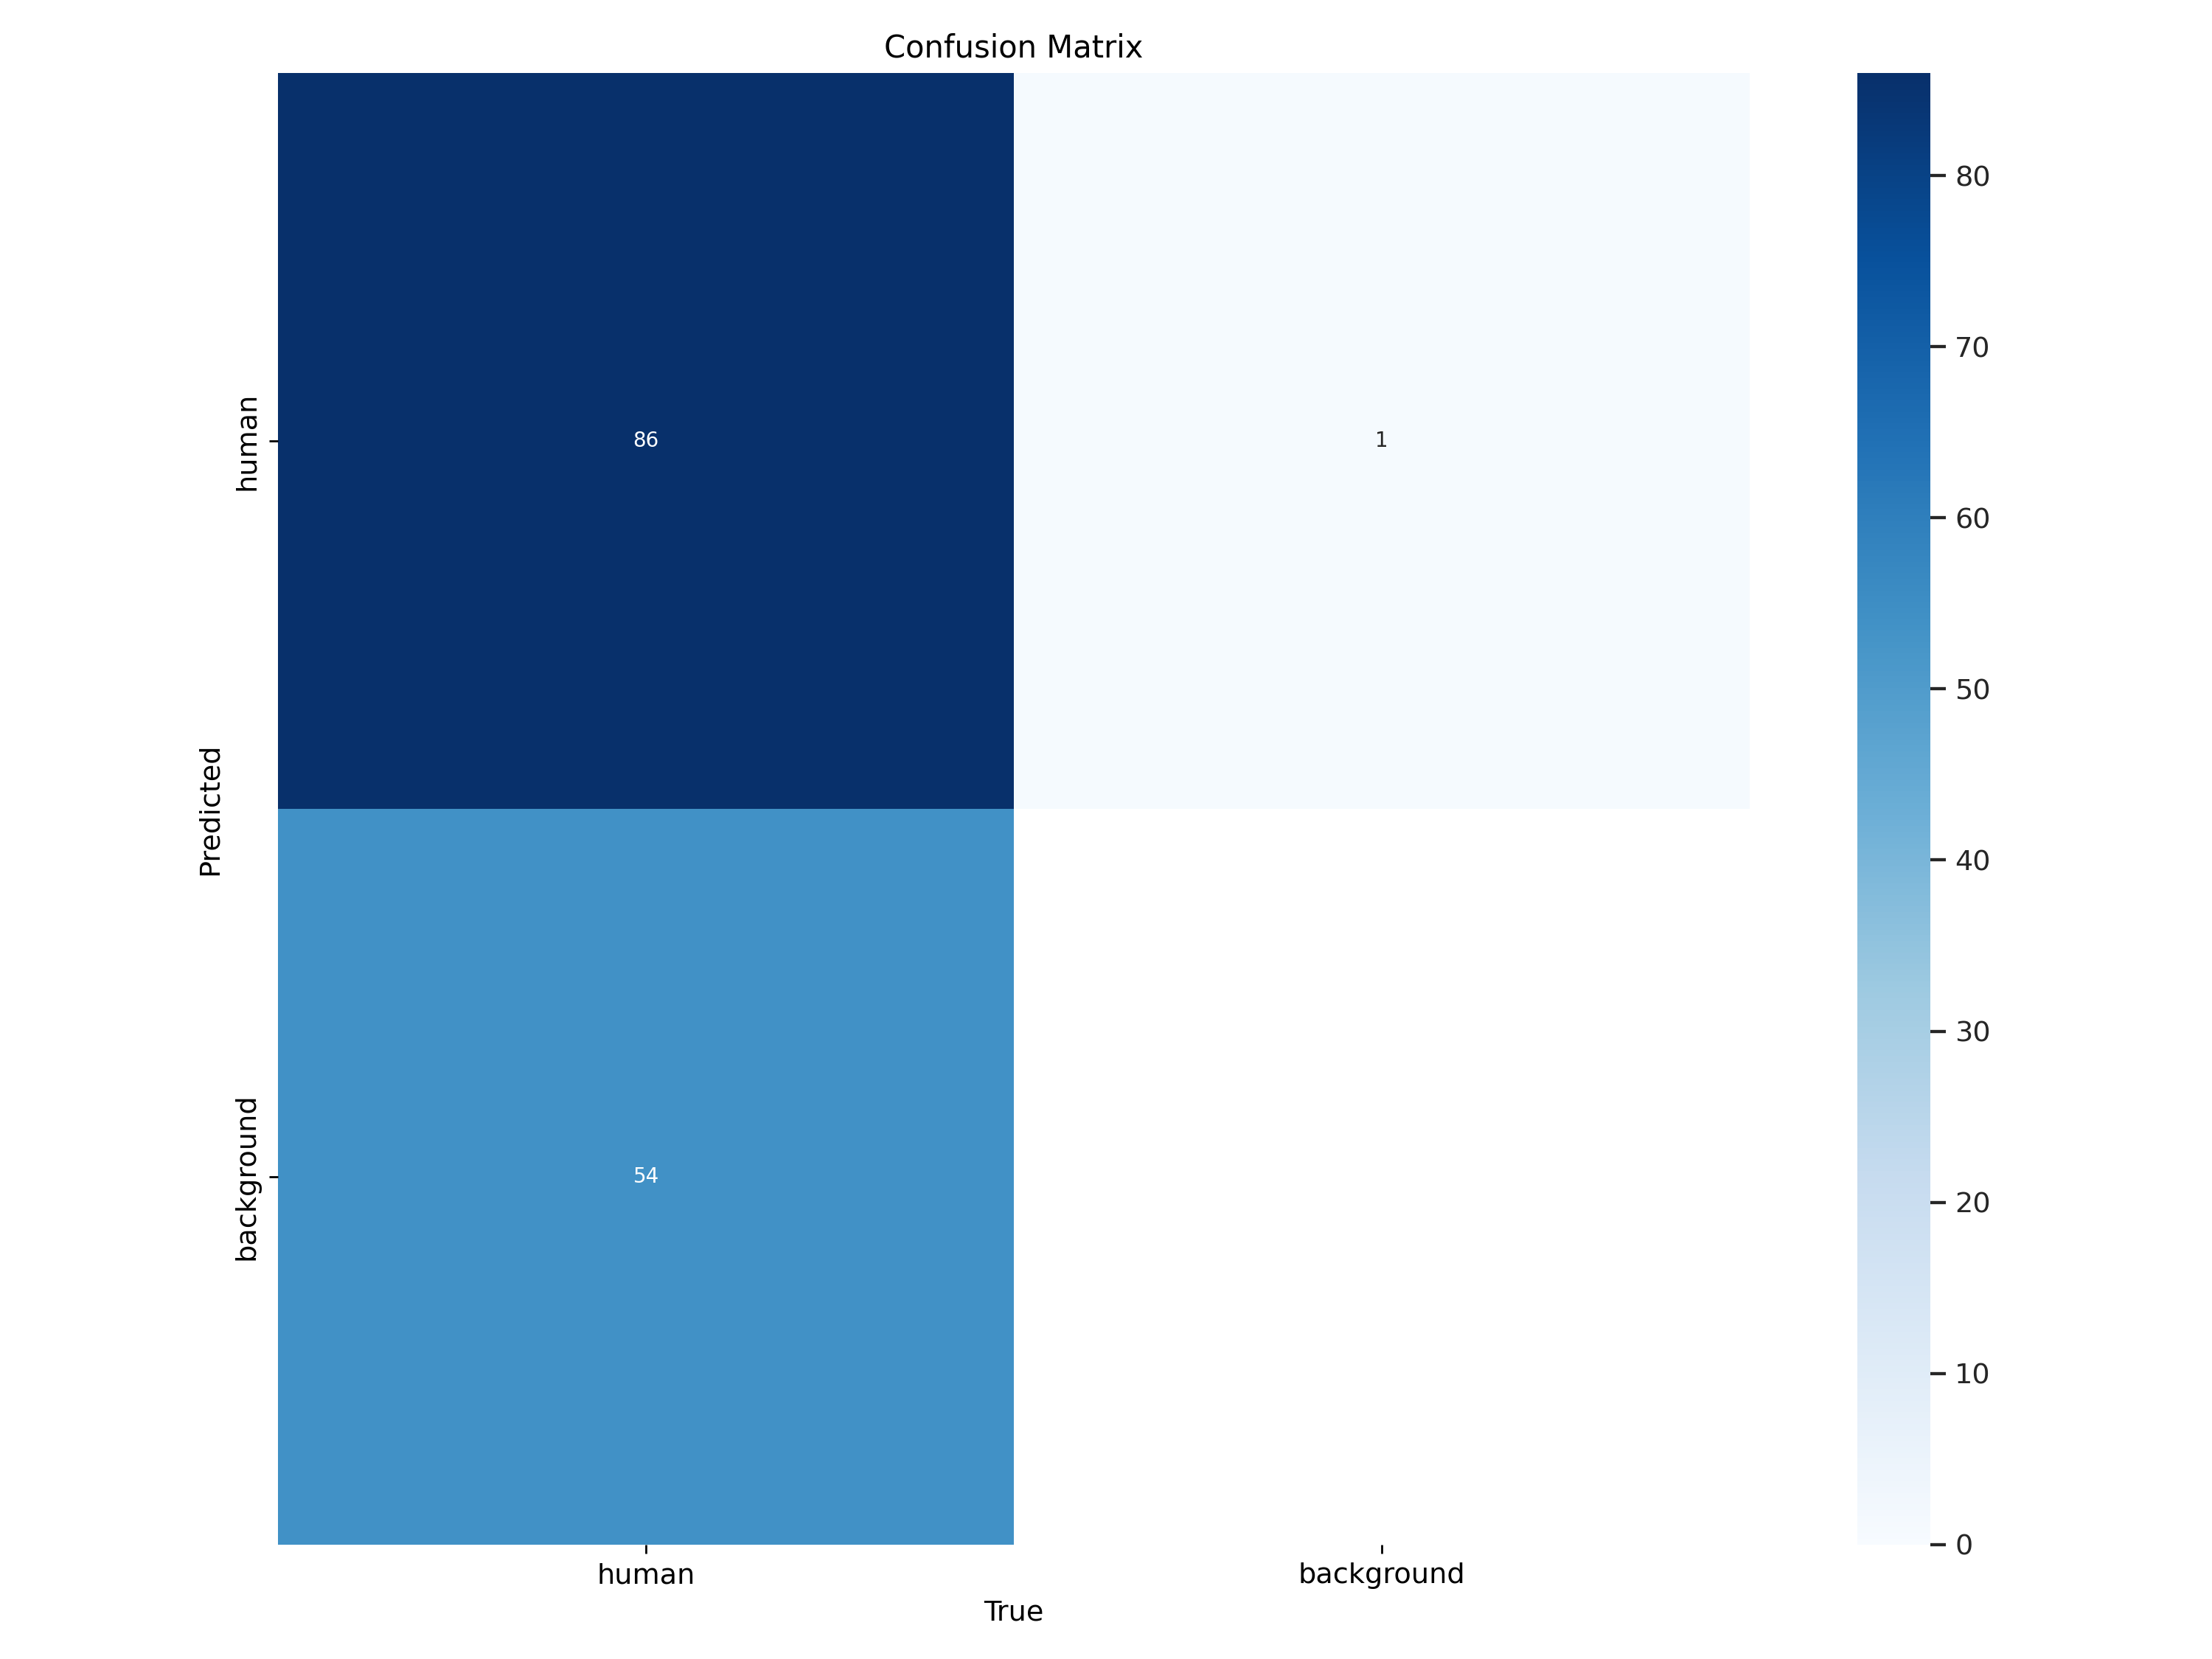

In [ ]:
%cd {HOME}
Image(filename=f'/content/runs/pose/val2/confusion_matrix.png', width=600)

/content


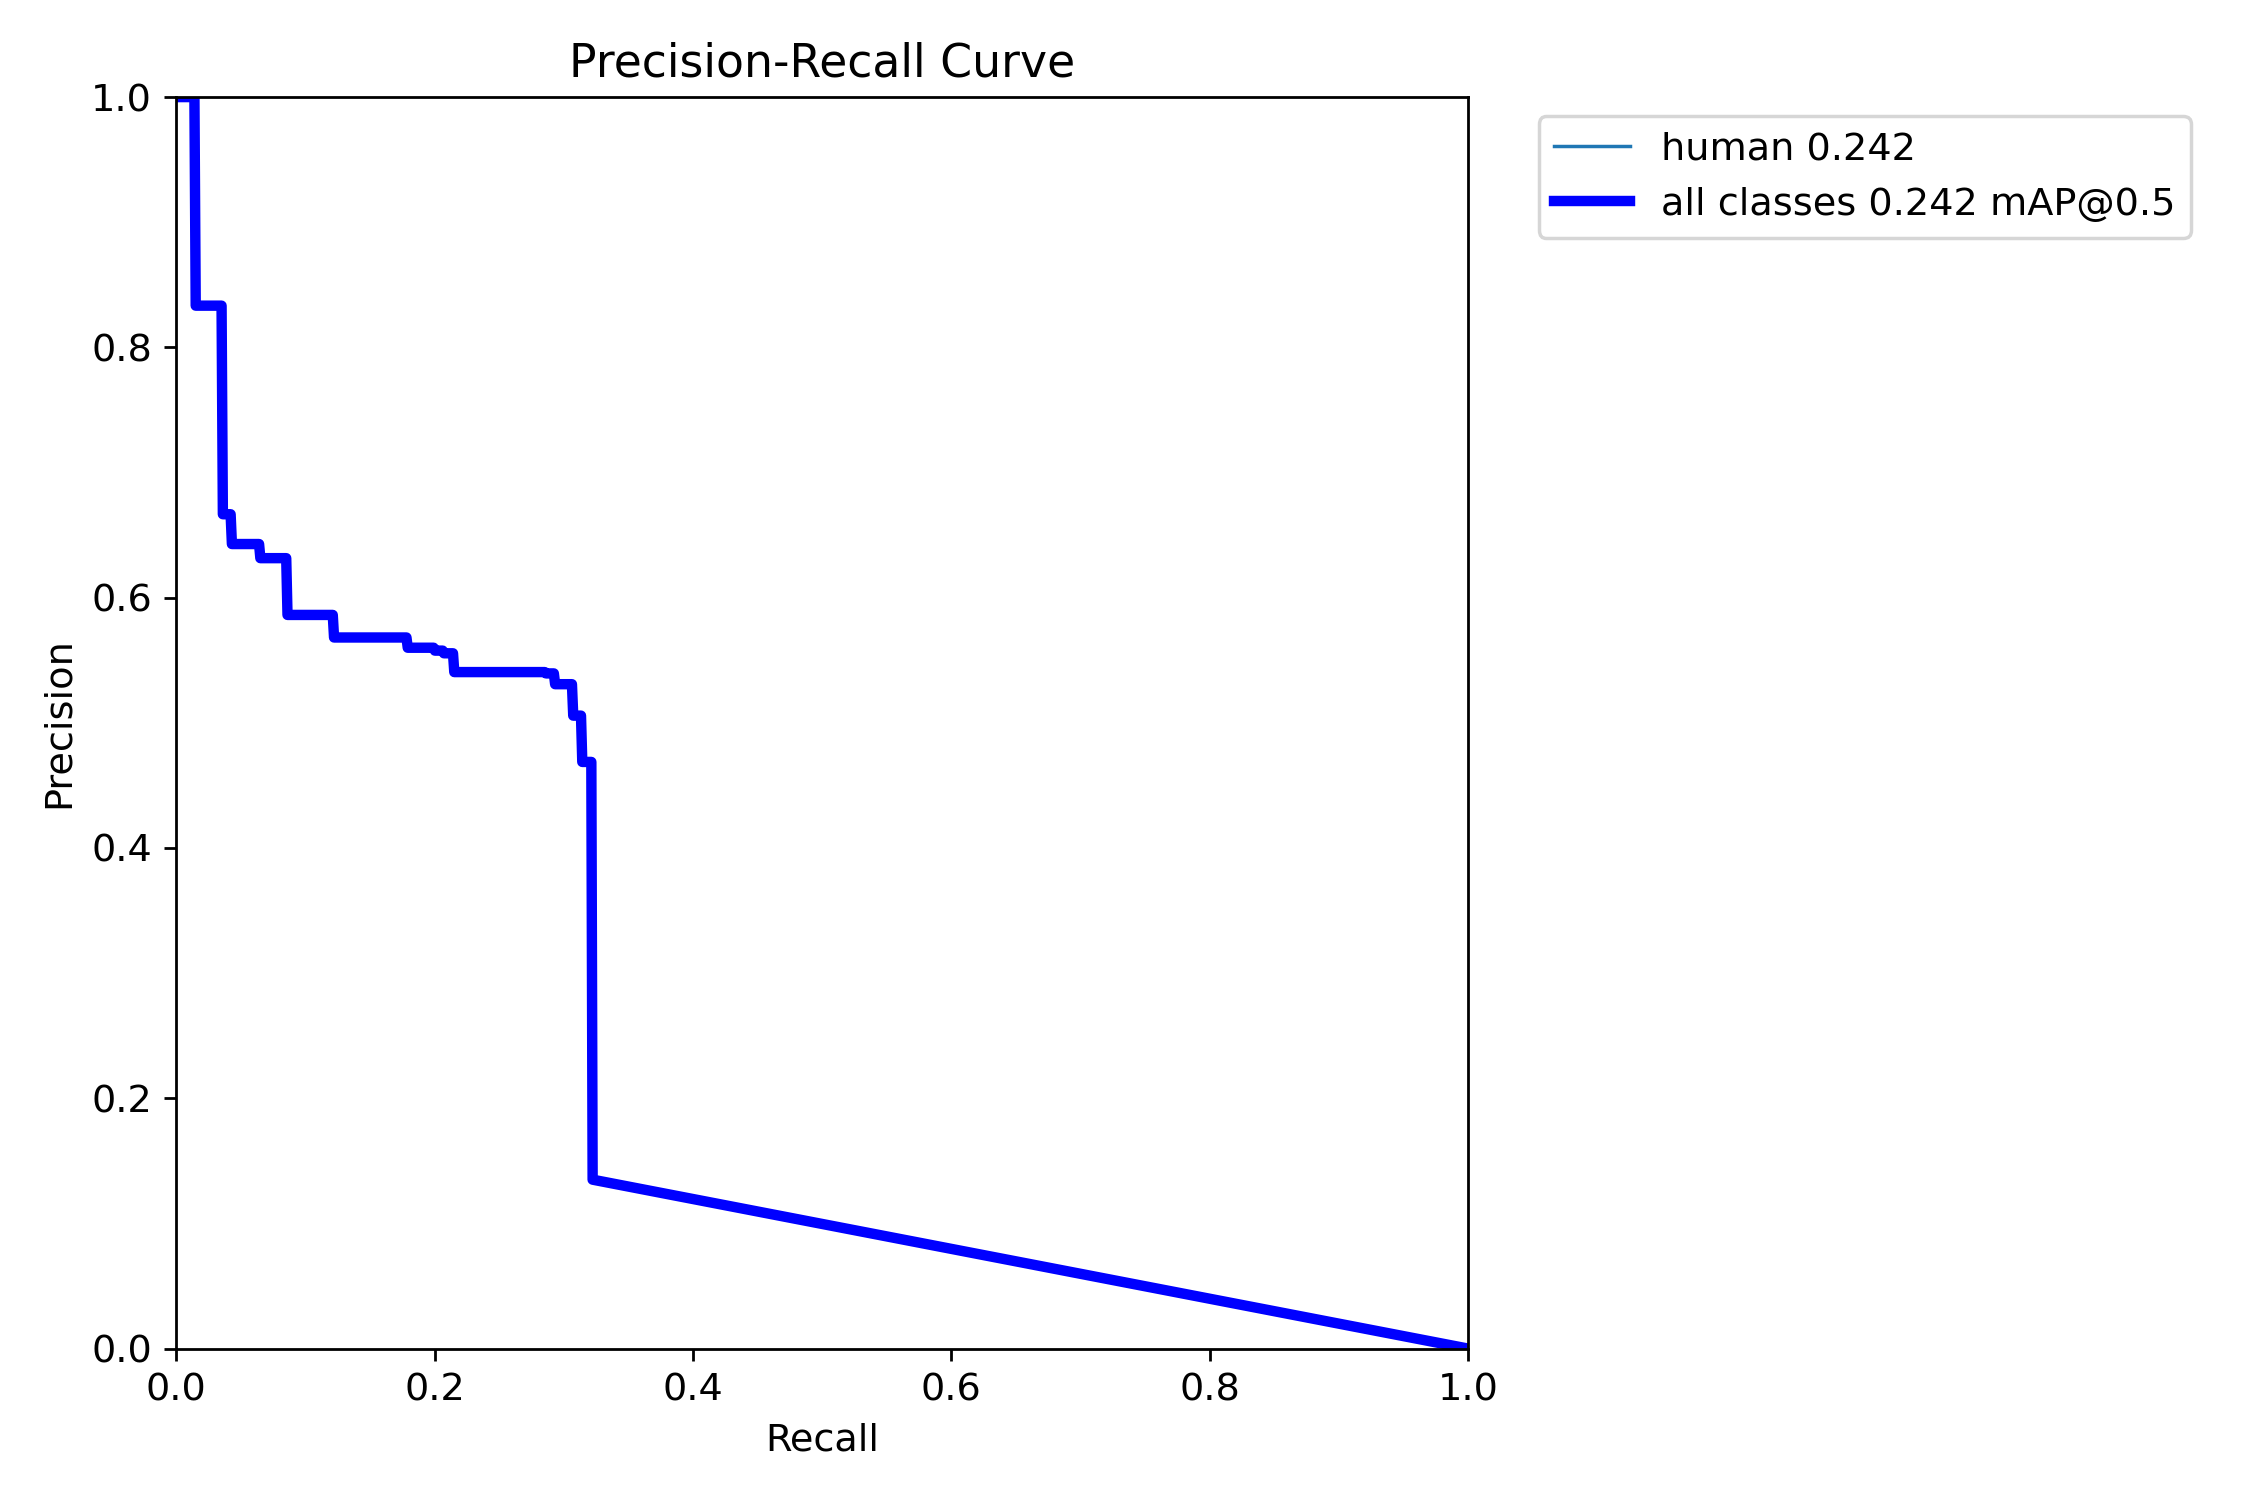

In [ ]:
%cd {HOME}
Image(filename=f'/content/runs/pose/val2/PosePR_curve.png', width=600)

# 🔵 **Inference with Custom Model**

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/pose/train/weights/best.pt conf=0.25 source=/content/datasets/CCTV/test/images save=True

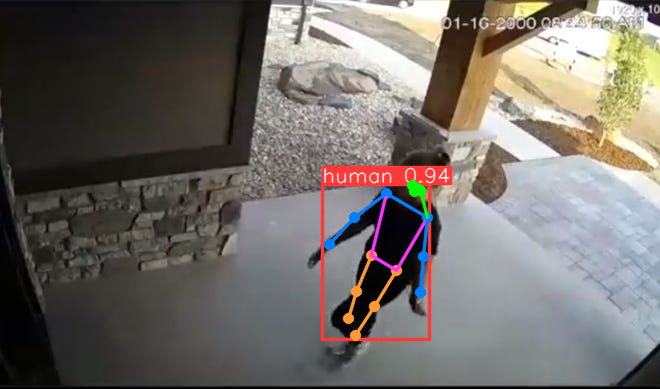

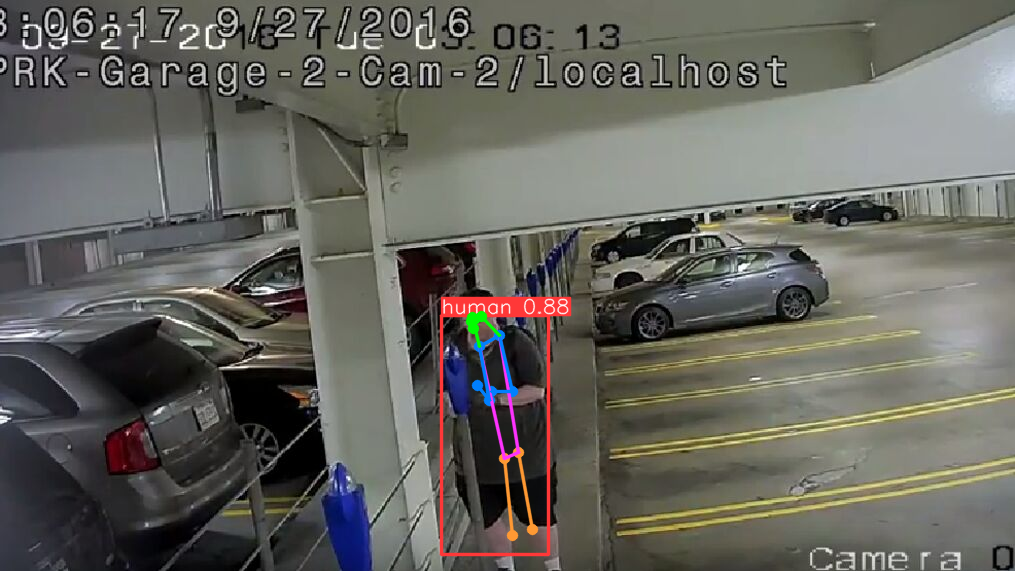

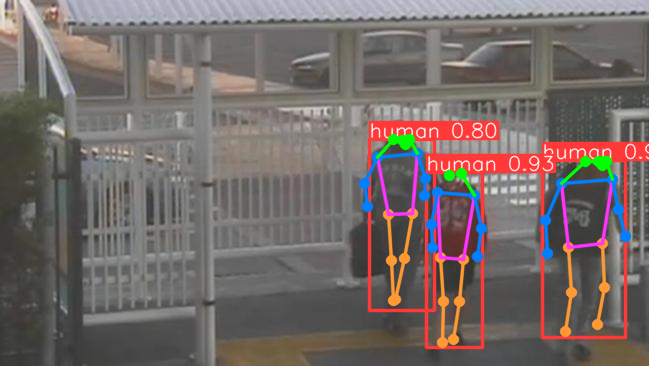

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/pose/predict/*.png')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")

In [ ]:
!yolo task=pose mode=predict model={HOME}/runs/pose/train/weights/best.pt conf=0.25 source=/content/CCTV.mp4 save=True

In [44]:
from moviepy.editor import *

path="/content/runs/pose/predict/CCTV.avi"

clip=VideoFileClip(path)

In [ ]:
clip.ipython_display(width=600)